## Lending Club Borrower Analysis Project

This project explores publicly available data from LendingClub.com. Lending Club connects people who need money (borrowers) with people who have money (investors). The aim of this project is to create a model to identify profiles of borrowers with a high probability of repaying their loans.

## Dataset Columns and Descriptions

- **credit.policy**: Indicates if the customer meets the credit underwriting criteria of LendingClub.com (1 if yes, 0 otherwise).
- **purpose**: The purpose of the loan. Possible values include:
  - `credit_card`
  - `debt_consolidation`
  - `educational`
  - `major_purchase`
  - `small_business`
  - `all_other`
- **int.rate**: The interest rate of the loan, as a proportion. For example, a rate of 11% would be stored as 0.11. Higher interest rates are assigned to borrowers deemed more risky by LendingClub.com.
- **installment**: The monthly installment amount owed by the borrower if the loan is funded.
- **log.annual.inc**: The natural logarithm of the self-reported annual income of the borrower.
- **dti**: The debt-to-income ratio of the borrower, calculated as the amount of debt divided by the annual income.
- **fico**: The FICO credit score of the borrower.
- **days.with.cr.line**: The number of days the borrower has had a credit line.
- **revol.bal**: The borrower's revolving balance, which is the amount unpaid at the end of the credit card billing cycle.
- **revol.util**: The borrower's revolving line utilization rate, representing the amount of the credit line used relative to the total credit available.
- **inq.last.6mths**: The number of inquiries made by creditors about the borrower in the last 6 months.
- **delinq.2yrs**: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
- **pub.rec**: The number of derogatory public records associated with the borrower, such as bankruptcy filings, tax liens, or judgments.


## Import Library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

In [3]:
# Install extra lib
!pip install xgboost
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

## Load data and check data

In [4]:
# Read CSV file
df_loan = pd.read_csv("loan_data.csv")
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37066 entries, 0 to 37065
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      37066 non-null  int64  
 1   purpose            37066 non-null  object 
 2   int_rate           37066 non-null  float64
 3   installment        37066 non-null  float64
 4   log_annual_inc     37066 non-null  float64
 5   dti                36966 non-null  float64
 6   fico               37066 non-null  int64  
 7   days_with_cr_line  37066 non-null  int64  
 8   revol_bal          37066 non-null  int64  
 9   revol_util         37054 non-null  float64
 10  inq_last_6mths     37066 non-null  int64  
 11  delinq_2yrs        37032 non-null  float64
 12  pub_rec            37066 non-null  int64  
 13  not_fully_paid     37066 non-null  int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 4.0+ MB


In [5]:
df_loan.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,credit_card,0.143,498.35,150000.0,15.70,694,37865,19748,0.674,3,5.0,0,0
1,1,home_improvement,0.110,870.29,55000.0,30.13,734,35947,11898,0.476,2,1.0,0,0
2,1,credit_card,0.088,785.32,165000.0,16.11,694,36373,20681,0.567,0,0.0,0,0
3,1,credit_card,0.170,285.03,40000.0,32.07,744,40269,8514,0.226,2,0.0,0,0
4,1,debt_consolidation,0.088,570.81,36000.0,23.73,714,38565,7555,0.256,1,0.0,0,1


## EDA

In [6]:
df_loan.count()

credit_policy        37066
purpose              37066
int_rate             37066
installment          37066
log_annual_inc       37066
dti                  36966
fico                 37066
days_with_cr_line    37066
revol_bal            37066
revol_util           37054
inq_last_6mths       37066
delinq_2yrs          37032
pub_rec              37066
not_fully_paid       37066
dtype: int64

In [7]:
df_loan[df_loan.isna().any(axis=1)]

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
251,1,credit_card,0.143,1201.33,0.0,NaN,679,42156,16858,0.371,1,0.000,2,1
1554,1,credit_card,0.088,826.66,0.0,NaN,709,38353,47472,0.682,1,0.000,0,0
1805,1,debt_consolidation,0.124,167.03,38000.0,5.56,689,39052,0,NaN,0,0.000,0,0
2226,1,home_improvement,0.082,814.70,120000.0,9.25,764,37987,0,NaN,0,0.000,0,0
2345,1,debt_consolidation,0.131,797.80,0.0,NaN,814,37316,97,0.016,0,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35967,1,house,0.082,1256.97,0.0,NaN,709,31686,0,0.000,278568,0.544,0,1
35969,1,home_improvement,0.139,928.66,1.0,NaN,709,33848,0,0.000,1648,0.323,0,1
36356,1,debt_consolidation,0.250,59.64,60000.0,9.40,719,39234,0,0.000,0,NaN,0,1
36503,1,credit_card,0.065,1225.24,0.0,NaN,739,30864,0,0.000,55481,0.937,0,1


In [11]:
df_loan.dropna(inplace=True)

In [12]:
df_loan[df_loan.isna().any(axis=1)]

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid


not_fully_paid
1    26775
0    10145
Name: count, dtype: int64


<Axes: xlabel='not_fully_paid'>

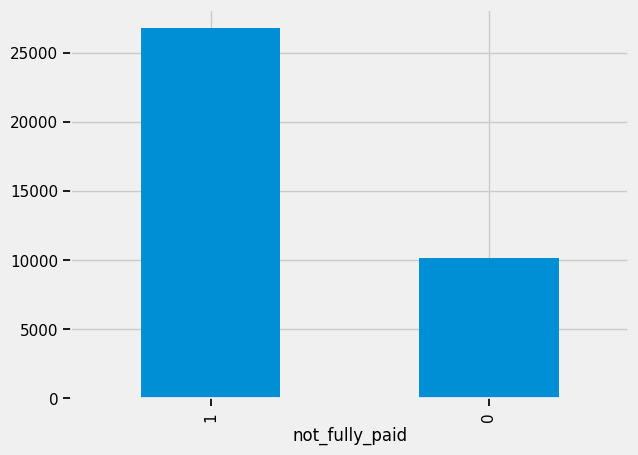

In [15]:
print(df_loan["not_fully_paid"].value_counts())
df_loan["not_fully_paid"].value_counts().plot(kind="bar")

## Pre-procesing data

In [24]:
object_cols = [name_col for name_col in df_loan.columns if df_loan[name_col].dtype == "O"]
print(object_cols)

['purpose']


In [25]:
df_loan["purpose"].value_counts()

purpose
debt_consolidation    19516
credit_card            9087
home_improvement       2836
other                  2496
major_purchase          899
medical                 465
house                   406
car                     384
vacation                313
small_business          269
moving                  234
renewable_energy         15
Name: count, dtype: int64

In [26]:
def process_purpose(s):
    return int(s == "debt_consolidation")

df_loan["purpose_int"] = df_loan["purpose"].apply(process_purpose)

In [27]:
df_loan["purpose_int"].value_counts()

purpose_int
1    19516
0    17404
Name: count, dtype: int64

In [28]:
df_loan.drop(columns=["purpose"], inplace=True)
df_loan.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_int
0,1,0.143,498.35,150000.0,15.70,694,37865,19748,0.674,3,5.0,0,0,0
1,1,0.110,870.29,55000.0,30.13,734,35947,11898,0.476,2,1.0,0,0,0
2,1,0.088,785.32,165000.0,16.11,694,36373,20681,0.567,0,0.0,0,0,0
3,1,0.170,285.03,40000.0,32.07,744,40269,8514,0.226,2,0.0,0,0,0
4,1,0.088,570.81,36000.0,23.73,714,38565,7555,0.256,1,0.0,0,1,1


In [29]:
df_loan["credit_policy"].value_counts()

credit_policy
1    36920
Name: count, dtype: int64

In [30]:
df_loan.drop(columns=["credit_policy"], inplace=True)
df_loan.head()

,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_int
0,0.143,498.35,150000.0,15.70,694,37865,19748,0.674,3,5.0,0,0,0
1,0.110,870.29,55000.0,30.13,734,35947,11898,0.476,2,1.0,0,0,0
2,0.088,785.32,165000.0,16.11,694,36373,20681,0.567,0,0.0,0,0,0
3,0.170,285.03,40000.0,32.07,744,40269,8514,0.226,2,0.0,0,0,0
4,0.088,570.81,36000.0,23.73,714,38565,7555,0.256,1,0.0,0,1,1


In [31]:
corr = df_loan.corr()
corr.style.background_gradient(cmap="coolwarm")

,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_int
int_rate,1.000000,0.042739,-0.055919,0.116065,-0.456244,0.086726,0.021824,0.133468,-0.003504,0.172759,0.046075,-0.036599,0.097478
installment,0.042739,1.000000,0.227242,0.084286,0.022387,-0.125390,0.170643,0.028539,0.226005,0.046695,-0.049956,-0.013016,0.140044
log_annual_inc,-0.055919,0.227242,1.000000,-0.121779,0.020853,-0.119594,0.151355,0.044720,0.177392,0.029868,-0.034424,-0.037026,-0.002927
dti,0.116065,0.084286,-0.121779,1.000000,-0.013244,-0.044598,0.077765,0.000342,0.081434,0.032497,-0.010775,-0.031361,0.054696
fico,-0.456244,0.022387,0.020853,-0.013244,1.000000,-0.120728,-0.021722,-0.188516,-0.065700,-0.307689,-0.191167,-0.027124,-0.024893
days_with_cr_line,0.086726,-0.125390,-0.119594,-0.044598,-0.120728,1.000000,-0.066180,-0.068710,-0.187349,-0.052515,-0.006409,-0.038029,-0.006357
revol_bal,0.021824,0.170643,0.151355,0.077765,-0.021722,-0.066180,1.000000,0.128898,-0.203446,-0.146972,-0.067585,-0.356469,0.029699
revol_util,0.133468,0.028539,0.044720,0.000342,-0.188516,-0.068710,0.128898,1.000000,-0.061745,-0.014098,-0.052424,-0.086816,0.004182
inq_last_6mths,-0.003504,0.226005,0.177392,0.081434,-0.065700,-0.187349,-0.203446,-0.061745,1.000000,0.220876,-0.056046,0.219629,-0.007000
delinq_2yrs,0.172759,0.046695,0.029868,0.032497,-0.307689,-0.052515,-0.146972,-0.014098,0.220876,1.000000,-0.030163,0.135084,0.007397


In [48]:
input_fields = df_loan.drop(columns=["not_fully_paid"]).columns.values

X = df_loan[input_fields]
y = df_loan["not_fully_paid"]

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=input_fields)

In [50]:
X.head()

,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_int
0,0.352941,0.285030,0.016129,0.015716,0.161290,0.760027,0.039118,0.029304,0.000005,0.333333,0.0,0.0
1,0.223529,0.511634,0.005914,0.030160,0.376344,0.666667,0.023568,0.020696,0.000003,0.066667,0.0,0.0
2,0.137255,0.459866,0.017742,0.016126,0.161290,0.687403,0.040966,0.024652,0.000000,0.000000,0.0,0.0
3,0.458824,0.155066,0.004301,0.032102,0.430108,0.877044,0.016865,0.009826,0.000003,0.000000,0.0,0.0
4,0.137255,0.329176,0.003871,0.023754,0.268817,0.794100,0.014965,0.011130,0.000002,0.000000,0.0,1.0


In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Train model 1 - Logicstic Regression, SMOTE

In [53]:
y_train.value_counts()

not_fully_paid
1    21484
0     8052
Name: count, dtype: int64

In [54]:
sm = SMOTE(k_neighbors=5)
X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

In [56]:
y_train_rs.value_counts()

not_fully_paid
1    21484
0    21484
Name: count, dtype: int64

In [58]:
!pip install --upgrade scikit-learn

  You can safely remove it manually.



   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB 330.3 kB/s eta 0:00:34
   ---------------------------------------- 0.1/11.0 MB 550.5 kB/s eta 0:00:20
    --------------------------------------- 0.2/11.0 MB 1.1 MB/s eta 0:00:11
   - -------------------------------------- 0.3/11.0 MB 1.6 MB/s eta 0:00:07
   -- ------------------------------------- 0.6/11.0 MB 2.5 MB/s eta 0:00:05
   --- ------------------------------------ 1.1/11.0 MB 3.7 MB/s eta 0:00:03
   ----- ---------------------------------- 1.6/11.0 MB 4.6 MB/s eta 0:00:03
   ------- -------------------------------- 2.2/11.0 MB 5.5 MB/s eta 0:00:02
   --------- ------------------------------ 2.7/11.0 MB 6.2 MB/s eta 0:00:02
   ----------- ---------------------------- 3.3/11.0 MB 6.8 MB/s eta 0:00:02
   ------------ --------------------------- 3.4/11.0 MB 6.9 MB/s eta 0:00:02
   -----

In [96]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [94]:
from sklearn.model_selection import GridSearchCV 

params_grid_logistic = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l1", "l2"],
    "solver": ['liblinear'],
    "max_iter": [1000]
}

grid_logistic = GridSearchCV(LogisticRegression() ,params_grid_logistic, cv=10)
grid_logistic.fit(X_train_rs, y_train_rs)

print("tuned hpyerparameters :(best parameters) ", grid_logistic.best_params_)
print('\033[1m' + "accuracy :", grid_logistic.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.7922410626876228


              precision    recall  f1-score   support

           0       0.73      0.66      0.69      2093
           1       0.87      0.91      0.89      5291

    accuracy                           0.84      7384
   macro avg       0.80      0.78      0.79      7384
weighted avg       0.83      0.84      0.83      7384



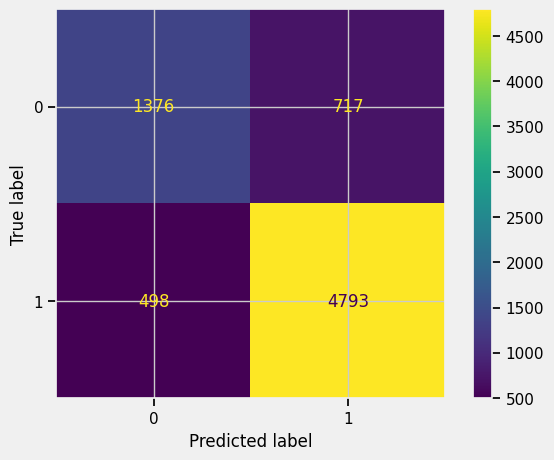

In [98]:
y_pred = grid_logistic.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## Train model 2 - XGBoost

In [109]:
import xgboost as xgb

parameters = {
    'max_depth': range (2, 10, 2),
    'n_estimators': range(60, 220, 100),
    'learning_rate': [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=parameters,
    cv=10,
)

grid_search.fit(X_train, y_train)
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=60, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.74      0.71      0.72      2093
           1       0.89      0.90      0.89      5291

    accuracy                           0.85      7384
   macro avg       0.81      0.80      0.81      7384
weighted avg       0.84      0.85      0.85      7384



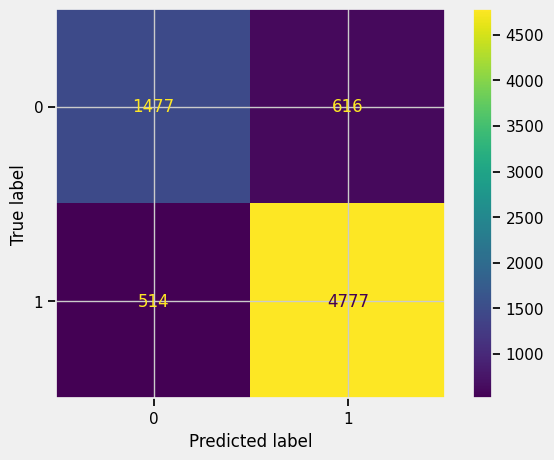

In [110]:
y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()